2017 Edition

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

In [2]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((np.array(p1)-np.array(p2))**2))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"


#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [3]:

def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
        
    return np.argmin([euclidean_distance(datapoint,centroid) for centroid in centroids])

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"


#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [4]:

np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    indices = np.random.choice(range(0, len(data)), size=k, replace=False)
    centroids = data[indices]
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"


#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

In [5]:

MAX_ITERATIONS = 100

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0.01):
    # if it reaches an iteration budget
    # check if the centroids don't move (or very slightly)
    if (num_iterations >= MAX_ITERATIONS or np.max(list(map(euclidean_distance, centroids, old_centroids))) < threshold):
        return True
    else:
        return False
    

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [6]:

# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    centroids = []
    for x in range(len(cluster)):
        centroids.append(np.mean(cluster[x], axis=0))
    return centroids


#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

In [7]:

# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(datapoint)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations, threshold=0.0001):
            break
    
    return centroids



Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:
/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


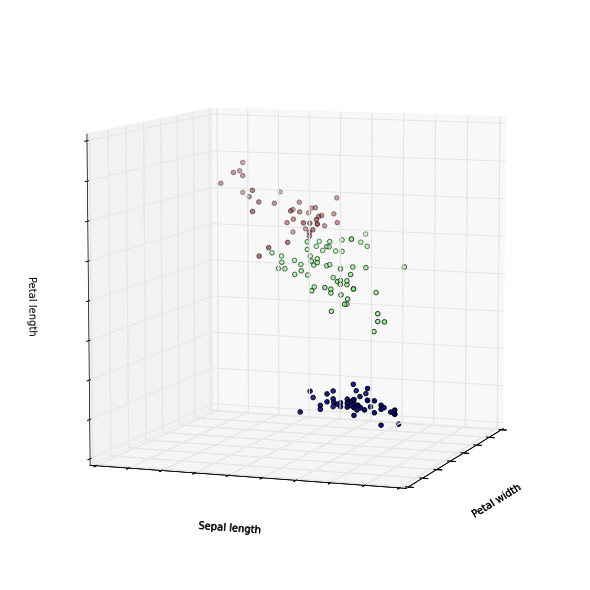

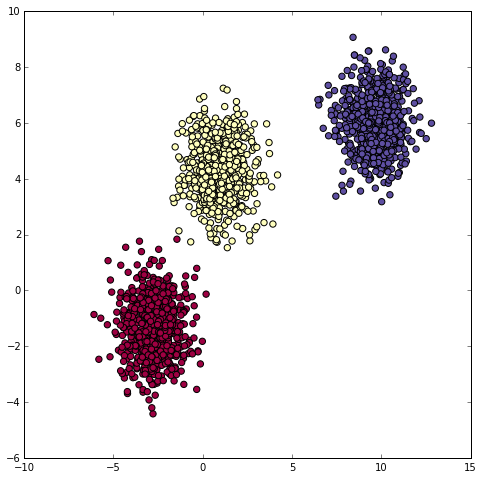

In [8]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.show()

# moon
# np.random.seed(0)
# X, y = datasets.make_moons(2000, noise=0.2)

# blob
np.random.seed()
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

# # Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_


<div class="alert alert-warning">
ANSWER: <br/>
- This algorithm seems run correctly. <br/>
- The result is depended on the randomness. For example, with the dataset blob, it sometimes mixes 2 cluster in 1 blob and the other 2 blobs are in a same cluster. <br/>
- It is better to use PCA to reduce dimension to 2 (or 3) and plot than select only 2 (or 3) first dimension to plot

</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [9]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [10]:

def parseLine(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = [vector[0]] + vector[4:]
    
    # convert each value from string to float
    #vector = vector #np.array(vector).astype(np.float)
    vector1 = np.array([float(x) for x in vector])

    return (label, vector1)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()

# number of connections
n = data.count()

print(n)

4898431


In [45]:
labelCount = labelsAndData.map(lambda x: x[0]).countByValue()

for item in labelCount.items():
    print(item)

('phf.', 4)
('imap.', 12)
('nmap.', 2316)
('back.', 2203)
('normal.', 972781)
('teardrop.', 979)
('rootkit.', 10)
('warezmaster.', 20)
('loadmodule.', 9)
('multihop.', 7)
('ipsweep.', 12481)
('guess_passwd.', 53)
('perl.', 3)
('ftp_write.', 8)
('satan.', 15892)
('spy.', 2)
('warezclient.', 1020)
('smurf.', 2807886)
('land.', 21)
('buffer_overflow.', 30)
('neptune.', 1072017)
('pod.', 264)
('portsweep.', 10413)


<div class="alert alert-warning">

NOTE: <br/>
- We can see that the data has 4898431 records in 23 classes. <br/>
- Some class of only several rows like 'phf', 'spy', 'perl', etc. Most of data belongs to class 'normal' (19.9%), 'smurf' (57.3%) and 'neptune'(21.9%) <br/>

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [11]:

clusters = KMeans.train(data, 2,  maxIterations=10, runs=10, initializationMode="random")


/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


In [13]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(point, center)

WSSSE = data.map(lambda point: error(point)**2).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))


Within Set Sum of Squared Error = 3.05254895755e+18


In [14]:
from sklearn.decomposition import PCA
from matplotlib.pyplot import cm 

def plot_cluster_data(data, model, sample_rate = 0.01):
    
    sample_data = data.sample(False, sample_rate)
    label = sample_data.map(lambda x: model.predict(x))
    
    X = np.array(sample_data.collect())
    Y = np.array(label.collect())
    
    pca = PCA(n_components=3)
    new_X = pca.fit_transform(X)
    
    #plot the clusters in color
    fig = plt.figure(1, figsize=(8, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
    plt.cla()
    
    labels = np.unique(Y)
    colors = iter(cm.rainbow(np.linspace(0, 1, len(labels))))
    
    for label in labels:
        indexes = Y == label
        c=next(colors)
        ax.scatter(new_X[indexes,0],new_X[indexes,1], new_X[indexes,2], c=c)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('X ')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


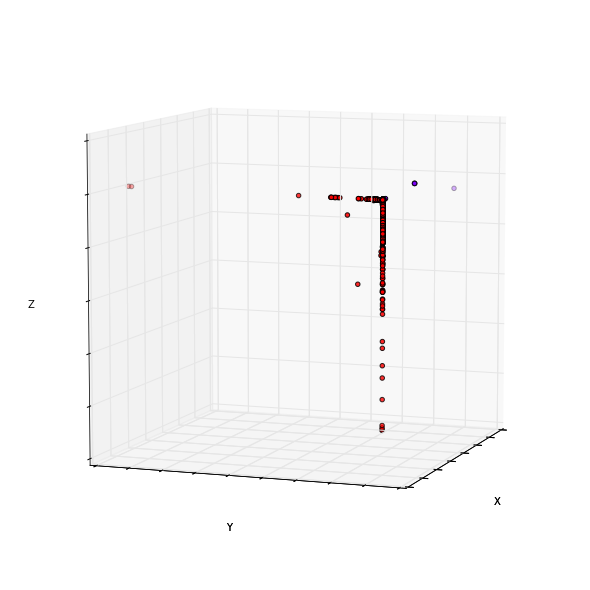

In [14]:
plot_cluster_data(data, clusters)

<div class="alert alert-warning">

ANSWER: <br/>
- This 3d plot use a sample 1% of dataset (around 50,000 points) to visualize. The data in above figure is applied dimentionality reduction to 3 dimension by using PCA. All figures in belows are used the same method. <br/>

- The shape of the plot, in general, is look like an 'L' letter. Some points have very large distance to the rest (sparse) <br/>

- The 'L' shape happens because the value range of each dimension. Some attributes have only (0,1), some goes upto 50,000 (or much more). Nomorlizing data is maybe a good approach in this case.



</div>

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [15]:

from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(point, closest_center)

SSE = data.map(lambda point: error(clusters, point)**2).reduce(lambda x, y: x + y)
print("Sum of Squared Error = " + str(SSE))



Sum of Squared Error = 3.05254895755e+18


<div class="alert alert-warning">
NOTE: The sum of squard error is significantly big because this is a big dataset. Taking the mean (MSE) is more reasonable 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

In [16]:
clusterLabelCount = labelsAndData.map(lambda x: (clusters.predict(x[1]), x[0])).countByValue()

In [12]:
for item in clusterLabelCount.items():
    print(item)

((0, 'loadmodule.'), 9)
((0, 'imap.'), 12)
((0, 'smurf.'), 2807886)
((0, 'land.'), 21)
((0, 'rootkit.'), 10)
((0, 'back.'), 2203)
((0, 'normal.'), 972781)
((0, 'pod.'), 264)
((0, 'spy.'), 2)
((0, 'guess_passwd.'), 53)
((0, 'phf.'), 4)
((0, 'nmap.'), 2316)
((0, 'portsweep.'), 10408)
((0, 'neptune.'), 1072017)
((0, 'teardrop.'), 979)
((0, 'satan.'), 15892)
((0, 'buffer_overflow.'), 30)
((0, 'perl.'), 3)
((0, 'warezclient.'), 1020)
((0, 'multihop.'), 7)
((0, 'warezmaster.'), 20)
((0, 'ipsweep.'), 12481)
((0, 'ftp_write.'), 8)
((1, 'portsweep.'), 5)


<div class="alert alert-warning">

ANSWER: <br/>
- The result is not useful. <br/>
- Only 5 points (over ~5 milion points) are assigned to cluster 1. These 5 points is belongs to class 'portsweep' and this class has 10413 points. 

</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

<div class="alert alert-warning">
NOTE: Compute the error for each point is insanely slow. The better way is using mapPartitions function instead of map or simply using computeCost method of the KMeans Model (which returns sum of squared distance to nearest centroid). <br/>
The score is MSE measurement.

</div>

In [54]:
KMEANS_MAX_ITERATIONS = 10
KMEANS_RUNS = 10

def clusteringScore(data, k):
    
    clusters = KMeans.train(data, k, maxIterations=KMEANS_MAX_ITERATIONS, runs=KMEANS_RUNS, initializationMode="random")
    
    # calculate mean square error
    #score = data.map(lambda point: error(clusters, point)**2).mean()
    size = data.count()
    score = clusters.computeCost(data)/size
    
    return score

k_array = range(20, 161, 10)

scores = [clusteringScore(data, k) for  k in k_array]


/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


In [55]:
for i in range(len(scores)):
    print('k = ', k_array[i], ', score (MSE) = ', scores[i])


k =  20 , score (MSE) =  223417917890.72034
k =  30 , score (MSE) =  202977550549.17743
k =  40 , score (MSE) =  197280127135.36154
k =  50 , score (MSE) =  202205350916.4756
k =  60 , score (MSE) =  202218393914.3763
k =  70 , score (MSE) =  197230307438.01178
k =  80 , score (MSE) =  202211084502.10205
k =  90 , score (MSE) =  197214228784.9009
k =  100 , score (MSE) =  197203903106.8062
k =  110 , score (MSE) =  197203413464.82455
k =  120 , score (MSE) =  197206499884.8133
k =  130 , score (MSE) =  197204785482.32593
k =  140 , score (MSE) =  197203938809.8895
k =  150 , score (MSE) =  197209909218.1437
k =  160 , score (MSE) =  197191723551.97095


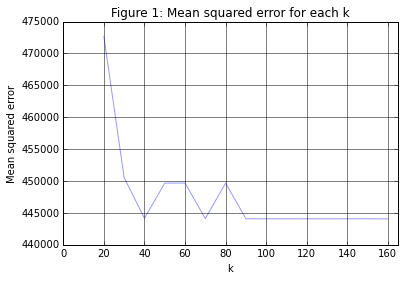

In [58]:
# plot results
plt.xlabel("k")
plt.ylabel("Mean squared error")
plt.title('Figure 1: Mean squared error for each k')
plt.grid(True,which="both",ls="-")

plt.plot(k_array, np.sqrt(scores) , alpha=0.4)
plt.xlim(0,165)
plt.show()


<div class="alert alert-warning">
ANSWER: <br/>
- In general, the mean squared error decreases when we increase k. <br/>
- For our training model, from k = 90, the MSE just slightly decreases. Sometimes, it fluctuates because of the randomness. If for each k, we increase the number of iterations and run several times, the result will be stable.<br/> 


</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [17]:
def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate the sum of each feature
    sums = data.reduce(lambda x1, x2: x1 + x2) # only work if x1 and x2 is numpy array
    print(sums)

    # calculate means
    means = sums/n

    # calculate the sum square of each feature
    sumSquares = data.map(lambda x: x**2).reduce(lambda x1, x2: x1 + x2)
    print(sumSquares)

    # calculate standard deviation of each feature
    stdevs = np.sqrt(sumSquares/n - means**2)
    print(stdevs)

    def normalize(point):
        new_stdevs = np.array([x if x != 0 else 1 for x in stdevs])
        return (point - means) / new_stdevs

    return data.map(normalize)

normalizedData = normalizeData(data).cache()
print(normalizedData.take(1))

[  2.36802060e+08   8.98676524e+09   5.35703589e+09   2.80000000e+01
   3.17800000e+03   3.90000000e+01   6.09250000e+04   1.57000000e+02
   7.03067000e+05   3.96200000e+04   3.34000000e+02   1.80000000e+02
   6.33610000e+04   5.82300000e+03   3.64000000e+02   5.00200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   1.64084428e+09
   1.44634545e+09   8.71775140e+05   8.72101730e+05   2.82468470e+05
   2.82786920e+05   3.86919313e+06   1.03746840e+05   1.38433600e+05
   1.14124176e+09   9.26852923e+08   3.69201228e+06   1.50436230e+05
   2.96380553e+06   3.16639800e+04   8.72367200e+05   8.71361620e+05
   2.83755350e+05   2.82440660e+05]
[  2.57433563e+12   4.34145810e+18   2.03795314e+18   2.80000000e+01
   8.99800000e+03   2.55000000e+02   1.07812100e+06   2.61000000e+02
   7.03067000e+05   7.28519560e+07   3.34000000e+02   3.20000000e+02
   7.59678130e+07   7.55510000e+04   3.74000000e+02   6.18200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   7.69775149e+1

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [59]:
k_array = range(20, 161, 10)
scores = [clusteringScore(normalizedData, k) for  k in k_array]


/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


In [60]:
for i in range(len(scores)):
    print('k = ', k_array[i], ', score = ', scores[i])

k =  20 , score =  20.150997229625105
k =  30 , score =  18.520945190847343
k =  40 , score =  14.247665664256779
k =  50 , score =  14.747768803851468
k =  60 , score =  15.391441117946998
k =  70 , score =  14.77911094334255
k =  80 , score =  12.556518801819209
k =  90 , score =  12.901762287614917
k =  100 , score =  14.555741689107343
k =  110 , score =  14.4478887425429
k =  120 , score =  13.49981350129615
k =  130 , score =  12.316064836966236
k =  140 , score =  12.07492390115798
k =  150 , score =  12.238711960083783
k =  160 , score =  10.801787367177141


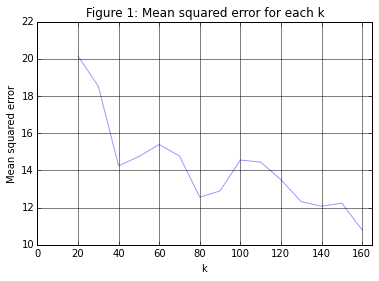

In [62]:
# plot results
plt.xlabel("k")
plt.ylabel("Mean squared error")
plt.title('Figure 1: Mean squared error for each k')
plt.grid(True,which="both",ls="-")

plt.plot(k_array, scores , alpha=0.4)
plt.xlim(0,165)
plt.show()


<div class='alert alert-warning'>
ANSWER: <br/>
- In general, the mean squared error decreases when we increase k. The smallest MSE value in this case is when k = 160. <br/>
- It still fluctuates because of the randomness. If for each k, we increase the number of iterations and run several times, the result will be more stable.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")
/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


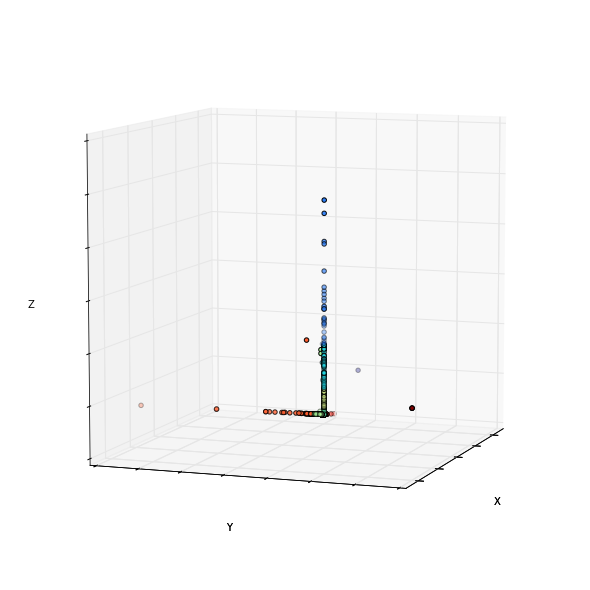

In [63]:
# for original data
clusters = KMeans.train(data, 90, maxIterations=KMEANS_MAX_ITERATIONS, runs=KMEANS_RUNS, initializationMode="random")
plot_cluster_data(data, clusters)

<div class="alert alert-warning">
NOTE: <br/>
- The cluster region changes along the shape of 'L' letter. <br/>
- This makes sense because the data set has two features that have significantly larger scale than the others. Hence, the Euclidean distance between points is had strong impact by these two features.
</div>

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")
/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


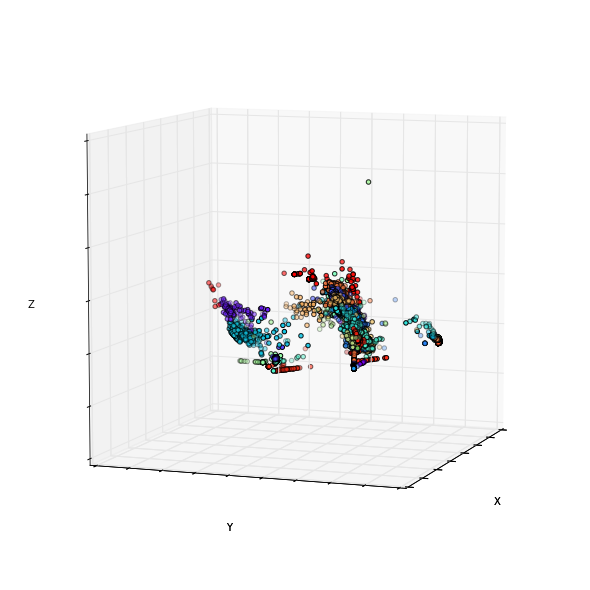

In [64]:

clusters = KMeans.train(normalizedData, 160, maxIterations=KMEANS_MAX_ITERATIONS, 
                        runs=KMEANS_RUNS, initializationMode="random")
plot_cluster_data(normalizedData, clusters)

<div class="alert alert-warning">
ANSWER: <br/>
- The shape of visualization changes completely after we perform normalization. <br/>
- Some point far away from the rest is still belong to the other cluster. <br/>
- With 160 cluster, it is hard to interpret which point is belonged to which cluster, but we can still see that points are near to each other are still belonged to 1 process.
</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [18]:
###@!SOLUTION@!####

# c: index of the column
def getValuesOfColumn(data, c):
    return data.map(lambda x: x[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()

In [19]:
###@!SOLUTION@!####
normalizedData = normalizeData(data).cache()

[  2.36802060e+08   8.98676524e+09   5.35703589e+09   2.80000000e+01
   3.17800000e+03   3.90000000e+01   6.09250000e+04   1.57000000e+02
   7.03067000e+05   3.96200000e+04   3.34000000e+02   1.80000000e+02
   6.33610000e+04   5.82300000e+03   3.64000000e+02   5.00200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   1.64084428e+09
   1.44634545e+09   8.71775140e+05   8.72101730e+05   2.82468470e+05
   2.82786920e+05   3.86919313e+06   1.03746840e+05   1.38433600e+05
   1.14124176e+09   9.26852923e+08   3.69201228e+06   1.50436230e+05
   2.96380553e+06   3.16639800e+04   8.72367200e+05   8.71361620e+05
   2.83755350e+05   2.82440660e+05]
[  2.57433563e+12   4.34145810e+18   2.03795314e+18   2.80000000e+01
   8.99800000e+03   2.55000000e+02   1.07812100e+06   2.61000000e+02
   7.03067000e+05   7.28519560e+07   3.34000000e+02   3.20000000e+02
   7.59678130e+07   7.55510000e+04   3.74000000e+02   6.18200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   7.69775149e+1

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [48]:
k_array = range(20, 161, 10)
scores = [clusteringScore(normalizedData, k) for  k in k_array]

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


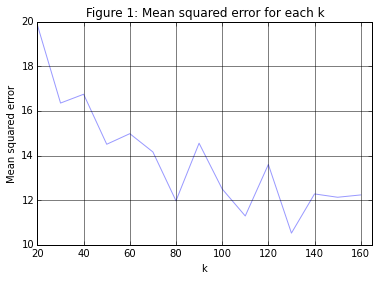

In [49]:
# plot results
plt.xlabel("k")
plt.ylabel("Mean squared error")
plt.title('Figure 1: Mean squared error for each k')
plt.grid(True,which="both",ls="-")

plt.plot(k_array, scores , alpha=0.4)
plt.xlim(20,165)
plt.show()

<div class="alert alert-warning">

ANSWER: <br/>

- In general, the mean squared error decreases when we increase k.
- It still fluctuates because of the randomness. If for each k, we increase the number of iterations and run several times, the result will be more stable.
- In this experiment, the smallest MSE value is obtained when k = 130. 

</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

<div class="alert alert-warning">
Based on the previous result, we choose k = 130 to train our model.
</div>

In [52]:
model_12 = KMeans.train(normalizedData, 130, maxIterations=KMEANS_MAX_ITERATIONS, initializationMode="random")

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


In [55]:
# calculate error
score = normalizedData.map(lambda point: error(clusters, point))
top_distance = score.top(100)
print("The biggest distance: ", top_distance[0])
print("The distance of 100th-farthest point: ", top_distance[-1])

The biggest distance:  3070.36370322
The distance of 100th-farthest point:  1469.21539518


<div class="alert alert-warning">
- The farthest distance away from the clusters is 3070.36370322 and 100th-farthest distance is 1469.21539518. <br/>
- The following part, we select these points and plot them along with other points (1% in our dataset)
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


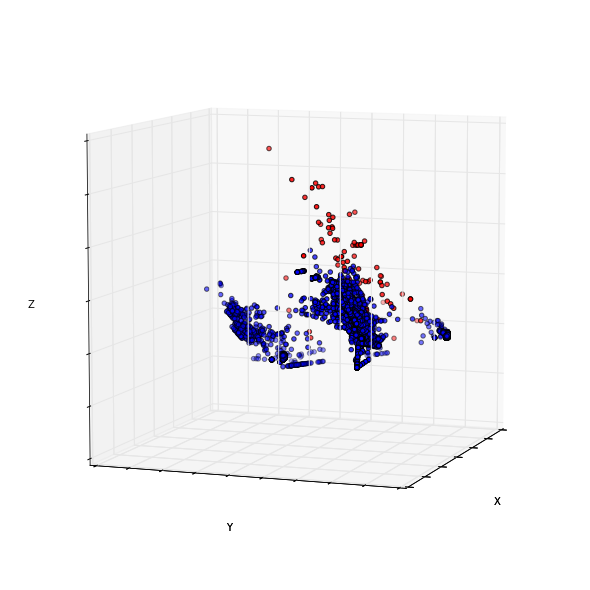

In [62]:
ano_threshold = top_distance[-1]
anomalous_points = normalizedData.filter(lambda point: error(clusters, point) >= ano_threshold).collect()

def plot_cluster_data_anomoly(data, ano_data, sample_rate = 0.01):
    
    sample_data = data.sample(False, sample_rate)
    
    X = np.array(sample_data.collect())
    
    pca = PCA(n_components=3)
    new_X = pca.fit_transform(X)
    ano_X = pca.transform(np.array(ano_data))
    
    #plot the clusters in color
    fig = plt.figure(1, figsize=(8, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
    plt.cla()
    

    ax.scatter(new_X[:,0],new_X[:,1], new_X[:,2], c='blue')
    ax.scatter(ano_X[:,0],ano_X[:,1], ano_X[:,2], c='red')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('X ')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
    

plot_cluster_data_anomoly(normalizedData, anomalous_points)

<div class="alert alert-warning">
- The considered anomoly points are in the red color. We can see that they are far away from the rest. 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

<div class="alert alert-warning">
The following part, we implement the version using entropy to evaluate the model. The negative point here is that we need the label for each row to calculate entropy, which is usually not available in pratice.
</div>

In [63]:
def entropy(values):
    ent = 0
    n = len(values)
    for x in set(values):
        ent -= values.count(x)/n *  np.log(values.count(x)/n);
    return ent*n

In [69]:
point_labels = labelsAndData.map(lambda x: x[0]).cache()

def clustering_score_entropy(data, labels, k):
    clusters = KMeans.train(data, k, maxIterations=KMEANS_MAX_ITERATIONS, initializationMode="random")
    
    # map to cluster for all points
    points_map = data.map(lambda x: clusters.predict(x))
    cluster_label = points_map.zip(point_labels)
    
    ent_score = cluster_label.groupByKey().mapValues(list).map(lambda x: calEntropy(x[1])).sum()/clusters.count()
    return ent_score


In [ ]:
#test with k = 160
print(clustering_score_entropy(normalizedData, point_labels, 160))

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>

In [50]:
import numpy as np


def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((np.array(p1)-np.array(p2))**2))

def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
        
    return np.argmin([euclidean_distance(datapoint,centroid) for centroid in centroids])

def kmeans_cluster_train(data, k, iterations=100, threshold=0.0001, seed=None):

    centroids = None
    c_centroids = None
    # select random k points as initial centroids
    centroids = data.takeSample(False, k, seed)
    

    # this function to calculate the sum of all points and number of points for each cluster
    def map_points_to_centroid_partition(points):
        centroids = c_centroids.value
        size = len(centroids) # number of items in a partition
        
        total_sum = np.zeros((size, len(centroids[0])))
        total_count = np.zeros(size)
        
        for point in points:
            best_centroid = find_closest_centroid(point, centroids)
            total_sum[best_centroid] += point
            total_count[best_centroid] += 1
            
        result = []
        for i in range(size):
            if (total_count[i] > 0):
                result.append((i, (total_sum[i], total_count[i])))
        
        return iter(result)
    
    # broadcast centroids
    c_centroids = sc.broadcast(centroids)
    
    for idx in range(iterations):

        # return (cluster_id, (sum, count))
        rdd = data.mapPartitions(map_points_to_centroid_partition).reduceByKey(lambda x, y: (x[0]+y[0],x[1]+y[1]))

        total = rdd.collectAsMap()
        
        new_centroids = [0 for i in range(len(centroids))]
        for key, value in total.items():
            new_centroids[key] = value[0]/value[1]
            
        # check converged
        epsilon = np.max(list(map(euclidean_distance, new_centroids, centroids)))
        print("Iteration ", idx, ": current threshold is ", epsilon)
        if (epsilon < threshold):
            centroids = new_centroids
            c_centroids = sc.broadcast(centroids)
            return c_centroids
        
        centroids = new_centroids
        c_centroids = sc.broadcast(centroids)

    return c_centroids


def cluster_find_closest_centroid(datapoint, centroids):
    #this function use to predict
    
    # find the index of the closest centroid of the given data point.
    return np.argmin([euclidean_distance(datapoint,centroid) for centroid in centroids.value])

def kmeans_cluster_predict(point, centroids):
    if (centroids is None):
        print("Need to train first")
        return -1;
    return find_closest_centroid(point, centroids)
        


In [54]:
%%timeit -n1 -r1
model = kmeans_cluster_train(normalizedData, 5, iterations=50)

Iteration  0 : current threshold is  2.57296621619
Iteration  1 : current threshold is  3.18590255101
Iteration  2 : current threshold is  2.21227812443
Iteration  3 : current threshold is  5.72510082638
Iteration  4 : current threshold is  0.66982693032
Iteration  5 : current threshold is  0.12299483351
Iteration  6 : current threshold is  0.0539407953735
Iteration  7 : current threshold is  0.0310025979024
Iteration  8 : current threshold is  0.0116379281734
Iteration  9 : current threshold is  0.00419639279007
Iteration  10 : current threshold is  0.00363612836916
Iteration  11 : current threshold is  0.0022966253617
Iteration  12 : current threshold is  0.00104104367081
Iteration  13 : current threshold is  0.0008813638063
Iteration  14 : current threshold is  0.00104343794523
Iteration  15 : current threshold is  0.00104612347276
Iteration  16 : current threshold is  0.00114960602501
Iteration  17 : current threshold is  0.000870848065513
Iteration  18 : current threshold is  0.00

<div class="alert alert-warning">
- From the beginning, we use rdd.map function to calculate the distance and select the nearest cluster for every points. However, this algorithm ran really slow. It might take 10 to 15 minutes execute a single iteration. <br/>
- The final version with rdd.mapPartitions performs much faster. The idea is that instead compute the distance for every point and transfer the result through network, we compute for all the points in each partition, then aggregate the result. The previous centroids will be broadcast to all partitions for faster access.<br/>
- As the exmaple above, the algorithm stops after 37 iterations and executes in about 14 mins.
</div>